In [1]:
%load_ext rpy2.ipython

Protocol used by Albertas to make this data: https://benchling.com/anavickas/f/lib_VNejBHt6-protocols/prt_2Bkfh557-meripseq/edit

HIV-1 IIIB Virus


https://aidsreagent.org/reagentdetail.cfm?t=viruses&id=607

We are starting from `fastq` files as raw data: 

## Trimming 

In [ ]:
%%bash 
cd ~/People/Judd/fastq
for f in *_L002_R1_001.fastq.gz; do  
    out=${f/\_S[1-9]*/.trim.fastq.gz}; 
    cutadapt -j 12 -q 15 -m 20 -a NNNAGATCGGAAGAGCACACGTCTGAACTCCAGTCA -o ../trim/$out $f; 
done

## Alignment

Unmmaped reads for each `fastq` file saved for later alignment to HIV genome 

Human genome: `gencode.v28.annotation.gtf`

In [ ]:
%%bash 
STAR --genomeLoad LoadAndExit --genomeDir /rumi/shams/abe/genomes/hg38/
for f in trim/*.fastq.gz;do
    out=${f/.trim.fastq.gz/_};
    out=${out/trim/bam};
    STAR --outSAMtype BAM SortedByCoordinate --readFilesCommand zcat --runThreadN 16 --genomeDir /rumi/shams/abe/genomes/hg38/ --readFilesIn $f --outFileNamePrefix $out --outReadsUnmapped Fastx;
done
STAR --genomeLoad Remove --genomeDir /rumi/shams/abe/genomes/hg38/

Firstly, HIV genome indices created by changing sequence provided by Judd to `.fa` format. It didn't work as we needed gtf file! 

Ok! I'm switching to the [HIV-1 clone pIIIB from USA, complete genome
](https://www.ncbi.nlm.nih.gov/nucleotide/EU541617.1?report=genbank&log$=nuclalign&blast_rank=1&RID=8B8ETWT201R) which is highly matched with Judd's clone (using Blast alignment). Then, I donwloaded `.fa` and `.gff3` format for downstream analysis. 

In [47]:
%%bash 
# # make hiv genome indices 
# bowtie2-build HIV/EU541617.1/EU541617.1.fasta HIV/EU541617.1/index
# # Aligning to hiv genome 
# for f in fastq_unmapped/*; do
# 	o=${f/.fastq/.bam};
#  	o=${o/fastq_unmapped/bam};
#  	bowtie2 --sensitive -N 1 -x HIV/EU541617.1/index -U $f | samtools sort -o $o;
# done

In [48]:
%%bash
# use STAR 
STAR --runThreadN 16 \
--runMode genomeGenerate \
--genomeDir HIV/EU541617.1/ \
--genomeFastaFiles HIV/EU541617.1/EU541617.1.fasta \
--sjdbGTFfile HIV/EU541617.1/EU541617.1.gff3 \
--sjdbOverhang 99 --genomeSAindexNbases 8 --sjdbGTFfeatureExon CDS

Apr 03 03:33:26 ..... started STAR run
Apr 03 03:33:26 ... starting to generate Genome files
Apr 03 03:33:26 ... starting to sort Suffix Array. This may take a long time...
Apr 03 03:33:26 ... sorting Suffix Array chunks and saving them to disk...
Apr 03 03:33:26 ... loading chunks from disk, packing SA...
Apr 03 03:33:26 ... finished generating suffix array
Apr 03 03:33:26 ... generating Suffix Array index
Apr 03 03:33:26 ... completed Suffix Array index
Apr 03 03:33:26 ..... processing annotations GTF
Apr 03 03:33:26 ... writing Genome to disk ...
Apr 03 03:33:26 ... writing Suffix Array to disk ...
Apr 03 03:33:26 ... writing SAindex to disk
Apr 03 03:33:26 ..... finished successfully


In [60]:
%%bash
# STAR --genomeLoad LoadAndExit --genomeDir HIV/EU541617.1/
for f in fastq_unmapped/*; do
	o=${f/.fastq/.bam};
	o=${o/fastq_unmapped/bam};
	echo STAR --outSAMtype BAM SortedByCoordinate --readFilesCommand cat --runThreadN 16 --genomeDir HIV/EU541617.1/ --readFilesIn $f --outFileNamePrefix $o --limitBAMsortRAM 1000000000;
# 	STAR --outSAMtype BAM SortedByCoordinate --readFilesCommand cat --runThreadN 16 --genomeDir HIV/EU541617.1/ --readFilesIn $f --outFileNamePrefix $o --limitBAMsortRAM 1000000000;
done
# STAR --genomeLoad Remove --genomeDir HIV/EU541617.1/

STAR --outSAMtype BAM SortedByCoordinate --readFilesCommand cat --runThreadN 16 --genomeDir HIV/EU541617.1/ --readFilesIn fastq_unmapped/s23.hiv.METTL14.input.fastq --outFileNamePrefix bam/s23.hiv.METTL14.input.bam --limitBAMsortRAM 1000000000
STAR --outSAMtype BAM SortedByCoordinate --readFilesCommand cat --runThreadN 16 --genomeDir HIV/EU541617.1/ --readFilesIn fastq_unmapped/s23.hiv.METTL14.m6A.fastq --outFileNamePrefix bam/s23.hiv.METTL14.m6A.bam --limitBAMsortRAM 1000000000
STAR --outSAMtype BAM SortedByCoordinate --readFilesCommand cat --runThreadN 16 --genomeDir HIV/EU541617.1/ --readFilesIn fastq_unmapped/s23.hiv.METTL3.input.fastq --outFileNamePrefix bam/s23.hiv.METTL3.input.bam --limitBAMsortRAM 1000000000
STAR --outSAMtype BAM SortedByCoordinate --readFilesCommand cat --runThreadN 16 --genomeDir HIV/EU541617.1/ --readFilesIn fastq_unmapped/s23.hiv.METTL3.m6A.fastq --outFileNamePrefix bam/s23.hiv.METTL3.m6A.bam --limitBAMsortRAM 1000000000
STAR --outSAMtype BAM SortedByCoordi

In [65]:
%%bash 
for f in bam/*Aligned.sortedByCoord.out.bam; do o=${f/Aligned.sortedByCoord.out.bam/}; mv -v $f $o; done 

renamed 'bam/s23.hiv.METTL14.input.bamAligned.sortedByCoord.out.bam' -> 'bam/s23.hiv.METTL14.input.bam'
renamed 'bam/s23.hiv.METTL14.m6A.bamAligned.sortedByCoord.out.bam' -> 'bam/s23.hiv.METTL14.m6A.bam'
renamed 'bam/s23.hiv.METTL3.input.bamAligned.sortedByCoord.out.bam' -> 'bam/s23.hiv.METTL3.input.bam'
renamed 'bam/s23.hiv.METTL3.m6A.bamAligned.sortedByCoord.out.bam' -> 'bam/s23.hiv.METTL3.m6A.bam'
renamed 'bam/s23.hiv.NT.input.bamAligned.sortedByCoord.out.bam' -> 'bam/s23.hiv.NT.input.bam'
renamed 'bam/s23.hiv.NT.m6A.bamAligned.sortedByCoord.out.bam' -> 'bam/s23.hiv.NT.m6A.bam'
renamed 'bam/s23.hiv.Virma.input.bamAligned.sortedByCoord.out.bam' -> 'bam/s23.hiv.Virma.input.bam'
renamed 'bam/s23.hiv.Virma.m6A.bamAligned.sortedByCoord.out.bam' -> 'bam/s23.hiv.Virma.m6A.bam'
renamed 'bam/s23.hiv.WTAP.input.bamAligned.sortedByCoord.out.bam' -> 'bam/s23.hiv.WTAP.input.bam'
renamed 'bam/s23.hiv.WTAP.m6A.bamAligned.sortedByCoord.out.bam' -> 'bam/s23.hiv.WTAP.m6A.bam'
renamed 'bam/s24.hiv.MET

All `bam`  files (mapped to human genome or hiv genome) renamed in this format: 
> `<sample>.<species>.<treatment>.<input/m6A>.bam`

### Id transfer 
Read gene names from `gtf` file

In [10]:
import pandas as pd 
import os
import feather as ft


def gtf_id_transfer(gtf):
    # awk code to extract gene ID and Name 
    gtf_raw = os.popen("cat " + gtf + " | awk 'BEGIN{FS=\"\t\"}{split($9,a,\";\"); if($3~\"gene\") print a[1]\"\t\"a[3]}' | sed 's/gene_id \"//' | sed 's/gene_name \"//' | sed 's/\"//g' | sed 's/ //g'").read().split('\n')
    # data frame 
    gtf_df = pd.DataFrame(
        # col: Names 
        data=[i.split('\t') for i in gtf_raw[:len(gtf_raw)-1]],
#         # index: ids 
#         index=[i.split('\t')[0] for i in gtf_raw[:len(gtf_raw)-1]],
        columns=['ID','Name'], dtype=str)
    return gtf_df

gtf = '/rumi/shams/genomes/hg38/gencode.v28.annotation.gtf'
gtf_df = gtf_id_transfer(gtf)

# pass data between R and Python using feather-format
ft.write_dataframe(gtf_df, 'gtf_df.ft')

In [ ]:
%%R 
library(feather)
gtf_df = read_feather('gtf_df.ft') %>% remove_rownames %>% column_to_rownames(var="ID")

# Peakcalling 

## Control

Comparing to RADAR package, exomepeak also claculate coverage for only non threted samples. We used different conda `environment` for exomepeak (and it takes long time to run!!). 

In [ ]:
library(exomePeak)
txdb <- makeTxDbFromGFF('/rumi/shams/genomes/hg38/gencode.v28.annotation.gtf',organism='Homo sapiens')
setwd("/rumi/shams/abe/People/Judd/bam")
print (txdb)
res <- exomepeak(
    TXDB=txdb,
    IP_BAM=list.files(pattern='human.NT.m6A.bam$'),
    INPUT_BAM=list.files(pattern='human.NT.input.bam$'),
    OUTPUT_DIR='../exomepeak',
    EXPERIMENT_NAME='control'
)
saveRDS(res, paste('../exomepeak','control', 'results.rds', sep='/'))

### Plot _Guitar_ 
Now, let's draw metagene plots for control samples:
(using seprate env: `Guitar`)

In [7]:
%reload_ext rpy2.ipython

In [6]:
%%R
library(Guitar)

In [4]:
%%R
txdb <- makeTxDbFromGFF('/rumi/shams/genomes/hg38/gencode.v28.annotation.gtf',organism='Homo sapiens')

R[write to console]: Import genomic features from the file as a GRanges object ... 
R[write to console]: OK

R[write to console]: Prepare the 'metadata' data frame ... 
R[write to console]: OK

R[write to console]: Make the TxDb object ... 
R[write to console]: OK



In [5]:
%%R
GuitarPlot(txTxdb = txdb,stBedFiles = list("exomepeak/control/peak.bed"),miscOutFilePrefix = "control")

[1] "20200325183907"
[1] "There are 203835 transcripts of 58381 genes in the genome."
[1] "total 203835 transcripts extracted ..."
[1] "total 94682 transcripts left after ambiguity filter ..."
[1] "total 94682 transcripts left after check chromosome validity ..."
[1] "total 11625 mRNAs left after component length filter ..."
[1] "total 56222 ncRNAs left after ncRNA length filter ..."
[1] "generate components for all tx"
[1] "generate components for mRNA"
[1] "generate components for lncRNA"
[1] "generate chiped transcriptome"
[1] "generate coverage checking ranges for tx"
[1] "generate coverage checking ranges for mrna"
[1] "generate coverage checking ranges for ncrna"
[1] "20200325184342"
[1] "import BED file exomepeak/control/peak.bed"
[1] "sample 10 points for Group1"
[1] "start figure plotting for tx ..."
[1] "start figure plotting for mrna ..."
[1] "start figure plotting for ncrna ..."


In [ ]:
# !magick -density 300 plots/control_mrna_test.pdf -flatten -quality 90 plots/control_mrna_test.png

### Motif analysis 

In [ ]:
%%bash 
cd exomepeak/control/
bedtools getfasta -name -s -fi /rumi/shams/genomes/hg38/hg38.fa -bed peak.bed -split -fo peak.fa
# prepare fasta file for FIRE
perl /flash/hani/bin/Tools/prep_seqs_for_teiser_run.pl peak.fa peaks
# run FIRE --doskipdiscovery=1
perl $FIREDIR/fire.pl --expfile=peaks_teiser.txt --exptype=discrete --fastafile_rna=peaks_teiser.fa --nodups=1 --dodna=0 --dodnarna=0 --species=human --doskipdiscovery=1 --motiffile_rna=motifs_of_interest.txt --oribiasonly=0
mv peaks_teiser.txt_FIRE/ motifs_of_interest_FIRE
# run FIRE --doskipdiscovery=0
perl $FIREDIR/fire.pl --expfile=peaks_teiser.txt --exptype=discrete --fastafile_rna=peaks_teiser.fa --nodups=1 --dodna=0 --dodnarna=0 --species=human --oribiasonly=0

# Running a custom pipeline 

Here we're using https://github.com/gold-lab/bed12ToGTF to make gtf file from control exomepeak result.

https://metacpan.org/pod/Bio::FeatureIO::gtf

In [243]:
%%bash
cat exomepeak/control/peak.bed | sort -k4 | \
# rename features peak by peak
awk -F "\t" '{OFS=FS}NR>1{$4=$4"_peak"}; cnt[$4]++{$4=$4"_"cnt[$4]} 1' | \
# bed12 to gtf
perl ../../Workflows/bed12ToGTF/bed12ToGTF.1.pl | \
awk '{gsub(/\"|\;/,"")}1''{gsub(/transcript_id/,"gene_id")}1''{gsub(/ exon_number [[:digit:]]/,"")}1' > exomepeak/control/peak.gtf

Using `featureCounts` to count reads which are present in control peak cordinates (found by `exomepeak`). 

In [244]:
%%bash
declare -a StringArray=('METTL14' 'METTL3' 'Virma' 'WTAP')
for enz in "${StringArray[@]}"; 
    do for f in bam/*human.$enz*.bam; 
        do out=${f/.bam/.fc}; out=${out/bam/peakcount}; 
            featureCounts -T 12 -O -t exon -g gene_id -a exomepeak/control/peak.gtf -o $out $f; 
    done;
done


        ==========     _____ _    _ ____  _____  ______          _____  
        =====         / ____| |  | |  _ \|  __ \|  ____|   /\   |  __ \ 
          =====      | (___ | |  | | |_) | |__) | |__     /  \  | |  | |
            ====      \___ \| |  | |  _ <|  _  /|  __|   / /\ \ | |  | |
              ====    ____) | |__| | |_) | | \ \| |____ / ____ \| |__| |
        ==========   |_____/ \____/|____/|_|  \_\______/_/    \_\_____/
	  v1.6.0

//========================== featureCounts setting ===========================\\
||                                                                            ||
||             Input files : 1 BAM file                                       ||
||                           S bam/s23.human.METTL14.input.bam                ||
||                                                                            ||
||             Output file : peakcount/s23.human.METTL14.input.fc             ||
||                 Summary : peakcount/s23.human.METTL14.input.fc

## Differential methylation

In [1]:
%reload_ext rpy2.ipython

In [3]:
%%R 
library(DESeq2)
library(tidyverse)
library(ggplot2)
require(ggrepel)
library(patchwork)
library(feather)
gtf_df = read_feather('gtf_df.ft') %>% remove_rownames %>% column_to_rownames(var="ID")

pca = list(); vol = list(); hist = list()

using `DESeq2` to find differential methylation peaks: 

In [4]:
%%R
all_dds = list()
for (treat in c('METTL14','METTL3','Virma','WTAP'
               )){
    treat.input <- list.files(path = 'peakcount',pattern=paste('human.',treat,".input.fc$",sep = ''))
    treat.m6A <- list.files(path = 'peakcount',pattern=paste('human.',treat,".m6A.fc$",sep = ''))
    files = c(treat.input,treat.m6A)
    # meta 
    reps <- rep(c('s23','s24'),2)
    ip <- c(rep('input',2),rep('m6A',2))
    conds <- paste(treat,ip, sep='.')
    all_conds <- paste(reps,treat,ip, sep='.')

    datalist <- lapply(files, function(x){read.table(file=paste('peakcount/', x, sep = ""),skip=1,sep='\t',header=TRUE,colClasses=c(NA, "NULL", "NULL", "NULL", "NULL", "NULL", NA),check.names=F)})
    m <- Reduce(function(...) merge(..., by=1, all = TRUE), datalist)
    rownames(m) <- m[,1]
    m <- m[,-1]
    m[is.na(m)]<-0
    m <- round(m)
    colnames(m) <- all_conds
    colData <- data.frame(cond = conds, rep = reps, row.names=all_conds)
    dds <- DESeqDataSetFromMatrix(countData = m, colData = colData, design = ~ cond)
    dds$cond <- relevel(dds$cond, ref=paste(treat,".input",sep = ''))
    dds <- DESeq(dds)
    
    all_dds[[treat]] = dds
    # normalized counts 
    ncu <- counts(dds, normalized=TRUE)
    res <- results(dds)
    res <- as.data.frame(res)
    # idtransfer
    peak_ids = strsplit(rownames(m), '_',)
    ids = unlist(lapply(peak_ids, '[[', 1))
    res$name = gtf_df[ids,]
    # save files 
    write.table(res, paste('deseq/',treat,'_peak_m6A_vs_input.txt',sep=''), sep="\t", quote=FALSE, col.names=NA)
    # Raw tabels 
    write.table(ncu, file=paste('deseq/',treat,'_peak_count_table_DE2norm.txt',sep=''), sep="\t", quote=FALSE, col.names=all_conds) 
    write.table(m, file=paste('deseq/',treat,'_peak_count_table_raw.txt',sep=''), sep="\t", quote=FALSE, col.names=all_conds)
}

R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[wr

### Plots 

### PCA

R[write to console]: found already estimated dispersions, replacing these

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: found already estimated dispersions, replacing these

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: found already estimated dispersions, replacing these

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: found already estimated dispersions, replacing these

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.6

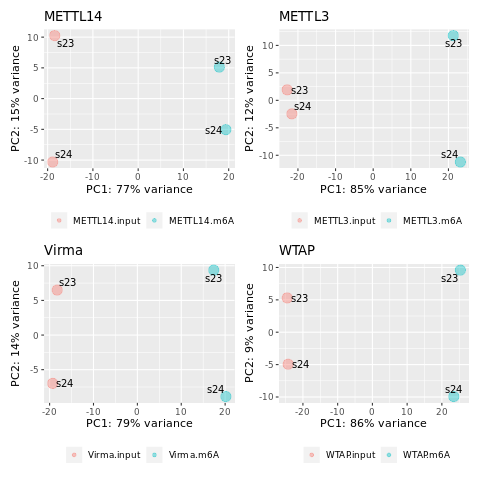

In [5]:
%%R
for (treat in c('METTL14','METTL3','Virma','WTAP')){
    dds = all_dds[[treat]]
    res <- results(dds)    
    cds <- estimateDispersions(dds)
    vsd <- varianceStabilizingTransformation(cds)
    ## PCA Plot 
    z <- plotPCA(vsd,intgroup=c("cond"), returnData=TRUE)
    z$rep <- substr(z$name,1,3)
    percentVar <- round(100 * attr(z, "percentVar"))
    pca[[treat]] <- ggplot(z, aes(PC1, PC2)) +
            ggtitle(treat) + 
            geom_point(aes(size = 2,  colour=cond), alpha = 4/10) +
            geom_text_repel(aes(label = rep),size = 3.5) +
            xlab(paste0("PC1: ",percentVar[1],"% variance")) +
            ylab(paste0("PC2: ",percentVar[2],"% variance")) +
            guides(size = FALSE) +
            theme(
                legend.title = element_blank(), 
                legend.position = "bottom"  )
}    
p = pca$METTL14 + pca$METTL3 + pca$Virma + pca$WTAP
ggsave("plots/peak_PCAs.png", plot = p, device = 'png', dpi = 300)
ggsave("plots/peak_PCAs.pdf", plot = p, device = 'pdf', dpi = 300)
p

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image



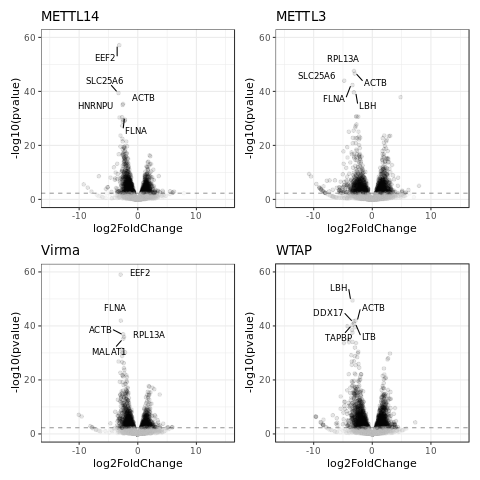

In [6]:
%%R
for (treat in c('METTL14','METTL3','Virma','WTAP')){
    dds = all_dds[[treat]]
    res <- results(dds)    
    res <- data.frame(res)
    # idtransfer
    peak_ids = strsplit(rownames(m), '_',)
    ids = unlist(lapply(peak_ids, '[[', 1))
    res$name = gtf_df[ids,]
    # significant thr 
    pvalue_lim = 0.005 #; log2FoldChange_lim = 5
    res$sig <- as.factor(
        res$pvalue < pvalue_lim
#         (res$log2FoldChange > log2FoldChange_lim & res$pvalue < pvalue_lim) |
#         (res$log2FoldChange < (-1)*log2FoldChange_lim & res$pvalue < pvalue_lim)
    )
    relevel(res$sig, ref=TRUE)
#     ## Volcano plot
    vol[[treat]] = res %>% ggplot(aes(x=log2FoldChange, y=-log10(pvalue),colour=sig, fill=sig)) +
            geom_point(aes(color = sig),alpha = 1/10) +
            ggtitle(treat) +
            xlim(c(-15,15)) +
            ylim(c(0,60)) +
            geom_hline(yintercept=-log10(pvalue_lim), linetype="dashed", alpha = 4/10) +
#             geom_vline(xintercept=log2FoldChange_lim, linetype="dashed", alpha = 4/10) +
#             geom_vline(xintercept=(-1)*log2FoldChange_lim, linetype="dashed", alpha = 4/10) +
            scale_color_manual(values = c("grey", "black")) +
            theme_bw() + theme(legend.position="none") +
            geom_text_repel(
                data = subset(res[order(res$pvalue),], sig == TRUE)[1:5,],
                aes(label = name),
                size = 3,
                box.padding = unit(0.35, "lines"),
                point.padding = unit(0.3, "lines")
            )
}
v = vol$METTL14 + vol$METTL3 + vol$Virma + vol$WTAP
ggsave("plots/peak_Volcanos.png", plot = v, device = 'png', dpi = 300)
ggsave("plots/peak_Volcanos.pdf", plot = v, device = 'pdf', dpi = 300)
v

In [14]:
%%R
library(Gviz)
library(Biostrings)
library(rtracklayer)
library(GenomicFeatures )

In [238]:
# %%R
# txdb <- makeTxDbFromGFF('/rumi/shams/genomes/hg38/gencode.v28.annotation.gtf',organism='Homo sapiens')

# %R bg_ip.treated 

# grtrack <- GeneRegionTrack(txdb, chromosome = chr, name = "Gene Model")
# gtrack <- GenomeAxisTrack()

# # %%R 
# # call_peaks('chr1')
# Tx <- transcripts(edb, filter = GeneNameFilter("BCL2L11"))

# # %%R
# peak_ploter <- function(treat,ymax, mins = rep(50,6), plus = rep(50,6), saveplot = '' ){
#     for (i in 1:6){
#         if (saveplot == 'pdf') pdf(paste("plots/hiv.",treat,'.',names(hiv_gr)[i],".pdf",sep=''), width=7, height=7, paper = "a4r")
#         if (saveplot == 'png') png(paste("plots/hiv.",treat,'.',names(hiv_gr)[i],".png",sep=''))
#         plotTracks(
#             list (gtrack, grtrack,
#                   get (paste('treated.s23', treat, sep ='.')),get(paste('treated.s24', treat, sep ='.')),
#                   get (paste('nontreated.s23', treat,sep ='.')),get(paste('nontreated.s24', treat,sep ='.'))
#                  ), 
#             type="l",
#             from=start(hiv_gr)[i] - mins[i], to=end(hiv_gr)[i] + plus[i] , ylim= c(-100,ymax[i]), 
#             main = paste(treat, names(hiv_gr)[i]),
#             add53=T,chromosome = "chr1",cex=1)
#         if (saveplot != '') dev.off() 
#     }
# }

[Wilcoxon signed rank test](http://www.sthda.com/english/wiki/one-sample-wilcoxon-signed-rank-test-in-r) amd t.test

[1] "METTL14"

	Wilcoxon signed rank test with continuity correction

data:  res$log2FoldChange
V = 14397000, p-value = 0.9007
alternative hypothesis: true location is less than 0


	One Sample t-test

data:  res$log2FoldChange
t = -0.32209, df = 7523, p-value = 0.7474
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -0.03046125  0.02186381
sample estimates:
   mean of x 
-0.004298719 

[1] "METTL3"

	Wilcoxon signed rank test with continuity correction

data:  res$log2FoldChange
V = 13900000, p-value = 0.09782
alternative hypothesis: true location is less than 0


	One Sample t-test

data:  res$log2FoldChange
t = -4.6995, df = 7520, p-value = 2.655e-06
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -0.12113479 -0.04982342
sample estimates:
  mean of x 
-0.08547911 

[1] "Virma"

	Wilcoxon signed rank test with continuity correction

data:  res$log2FoldChange
V = 14295000, p-value = 0.7599
alternative hypothesis:

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image



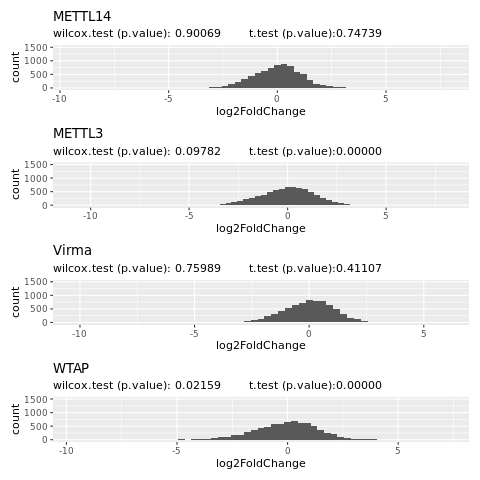

In [8]:
%%R
for (treat in c('METTL14','METTL3','Virma','WTAP')){
    dds = all_dds[[treat]]
    res <- results(dds)    
    res = data.frame(res)
    d <- res$log2FoldChange[!is.na(res$log2FoldChange)]
    w <- wilcox.test(res$log2FoldChange,mu = 0, alternative = "less")
    
    t <- t.test(res$log2FoldChange, mu=0)

    print (treat)
    print (w)
    print (t)
    
    hist[[treat]] = ggplot(res, aes(x=log2FoldChange)) +
            ggtitle(
                treat, 
                sprintf("wilcox.test (p.value): %.5f \t t.test (p.value):%.5f", w$p.value, t$p.value)
            ) +
            ylim(c(-10,1500)) +
            geom_histogram(binwidth=0.3)
}
h = hist$METTL14 / hist$METTL3 / hist$Virma / hist$WTAP
ggsave("plots/peak_Histograms.png", plot = h, device = 'png', dpi = 300)
ggsave("plots/peak_Histograms.pdf", plot = h, device = 'pdf', dpi = 300)
h

## Pairwise correlation of each treatments 
http://www.sthda.com/english/wiki/correlation-matrix-a-quick-start-guide-to-analyze-format-and-visualize-a-correlation-matrix-using-r-software

In [233]:
%%R
library(Hmisc)
library(corrplot)
library(pheatmap)

In [234]:
%%R
all_fc = data.frame(
    METTL14 = data.frame(results(all_dds$METTL14))$log2FoldChange,
    METTL3 = data.frame(results(all_dds$METTL3))$log2FoldChange,
    Virma = data.frame(results(all_dds$Virma))$log2FoldChange,
    WTAP = data.frame(results(all_dds$WTAP))$log2FoldChange,
    row.names = rownames(data.frame(results(all_dds[[1]])))
)
colSums(is.na(all_fc))

METTL14  METTL3   Virma    WTAP 
      5       8       3       3 


In [235]:
%%R
res2 <- rcorr(as.matrix(all_fc))
# # Extract the correlation coefficients
# res2$r
# # Extract p-values
# res2$P

pdf("plots/Corrplot.pdf", width=7, height=7)
c = corrplot(res2$r, type="upper", order="hclust", method="pie",
         p.mat = res2$P, sig.level = 0.01, insig = "blank")
dev.off()
png("plots/Corrplot.png")
c = corrplot(res2$r, type="upper", order="hclust", method="pie",
         p.mat = res2$P, sig.level = 0.01, insig = "blank")
dev.off()

png 
  2 


In [100]:
%%R
res2$r

          METTL14    METTL3     Virma      WTAP
METTL14 1.0000000 0.5874376 0.6548376 0.6265873
METTL3  0.5874376 1.0000000 0.6038699 0.6120947
Virma   0.6548376 0.6038699 1.0000000 0.6135741
WTAP    0.6265873 0.6120947 0.6135741 1.0000000


R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image



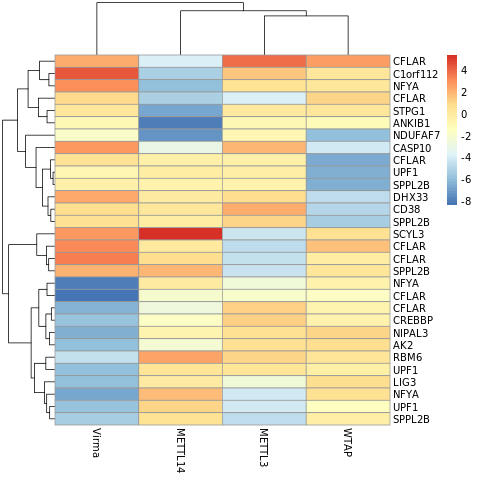

In [236]:
%%R
# mostVar Calculate the top n most variable genes in a matrix of gene expression data
# https://rdrr.io/github/abc-igmm/transcripTools/man/mostVar.html
mostVar <- function(data, n, i_want_most_var = TRUE) {
  data.var <- apply(data, 1, stats::var)
  data[order(data.var, decreasing = i_want_most_var)[1:n],] 
}
# scale - Z-Score
fc <- data.frame(apply(all_fc,2,scale, center=TRUE, scale=TRUE), row.names=rownames(all_fc))

# idtransfer
peak_ids = strsplit(rownames(all_fc), '_',)
ids = unlist(lapply(peak_ids, '[[', 1))

# filter most variable genes
fc = mostVar(fc,30)
# Plot heatmap
h1 <- pheatmap(fc, labels_row = gtf_df[ids,])
ggsave('plots/peak_mostVar_Heatmap.png', plot = h1, device = 'png', dpi = 300)
ggsave('plots/peak_mostVar_Heatmap.pdf', plot = h1, device = 'pdf', dpi = 300)

## iPAGE
Enrichment analysis 

In [56]:
%%bash 
declare -a StringArray=('METTL14' 'METTL3' 'Virma' 'WTAP')
for treat in "${StringArray[@]}"; do
#     awk 'NR>1{arr[$1]   += $3; count[$1] += 1}END{for (a in arr) {print substr(a,1,15)"\t"arr[a]/count[a]}}' deseq/${treat}_peak_m6A_vs_input.txt > deseq/${treat}_peak_m6A_vs_input.ave.txt
    for f in `ls -d /flash/hani/bin/iPAGEv1.0/PAGE_DATA/ANNOTATIONS/human_ensembl*`; do
        base=`basename "$f"`
        perl $PAGEDIR/page.pl --expfile=deseq/${treat}_m6A_vs_input.peak_ave.txt \
        --species=$base --exptype=continuous --ebins=11 --nodups=1
        mv -v deseq/${treat}_peak_m6A_vs_input.ave.txt_PAGE/ ipage/${treat}_peak_m6A_vs_input_${base}/
#         echo magick -density 300 ipage/${treat}_peak_m6A_vs_input_${base}/${treat}_peak_m6A_vs_input.peak_ave.txt.summary.pdf -flatten -quality 90 plots/ipage.${treat}_peak_m6A_vs_input_${base}.png
#         echo '<img src="plots/ipage.'${treat}_peak_m6A_vs_input_${base}.png'" style="height:300px">'
    done
done

# TEISER
https://github.com/goodarzilab/TEISER

In [ ]:
# def run_teiser(difffile):
#     genelist = '/avicenna/yikai/Miscellaneous/%s_targets' % difffile.split('/')[0].replace('enrichment_', '') + '/genelist_' + difffile.split('_')[-1]
#     subprocess.call('perl /avicenna/bins/TEISERv1.1/run_mi_gene_list.pl --expfile=%s --genefile=%s --exptype=continuous --ebins=15 --species=human_cds --doremovedups=0 --doremoveextra=0'%(difffile, genelist), shell = True)

In [5]:
# %%bash
# declare -a StringArray=('METTL14' 'METTL3' 'Virma' 'WTAP')
# for treat in "${StringArray[@]}"; do
#     # ave duplicate: peaks  
# #     awk 'NR>1{arr[$1]   += $3; count[$1] += 1}END{for (a in arr) {print substr(a,1,15)"\t"arr[a]/count[a]}}' deseq/${treat}_peak_m6A_vs_input.txt > deseq/${treat}_peak_m6A_vs_input.ave.txt
#     # ave duplicate: exons 
# #     awk 'NR>1{arr[$1]   += $2; count[$1] += 1}END{for (a in arr) {print a"\t"arr[a]/count[a]}}' deseq/${treat}_peak_m6A_vs_input.ave.txt > deseq/${treat}_peak_m6A_vs_input.ave.c.txt
#     perl $TEISERDIR/run_mi_gene_list.pl \
#     --expfile=deseq/${treat}_peak_m6A_vs_input.ave.c.txt \
# #     --genefile=miRDB_miR-296-5p.predicted_targets_ens.list \
#     --exptype=continuous \
#     --ebins=7 \
#     --species=human \
#     --doremovedups=0 \
#     --doremoveextra=0
# done

### using bam to bed for cov count 

1. `intersectBed -split` make it work with bed12 file

3. make a intersect gtf to extract names for later. `

In [108]:
# %%bash 
# bamToBed -i bam/s23.human.METTL3.input.bam | intersectBed -s -split -wo -a - -b exomepeak/control/peak.bed | awk '{print $10}' | sort  tail

In [109]:
# %%bash 
# bamToBed -i bam/s23.human.METTL3.input.bam | intersectBed -s -split -wo -a - -b exomepeak/control/peak.bed \
# | cut -f10 | sort | uniq -c | awk '{ print $2 "\t" $1}' | head

In [89]:
%%R 
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.2 LTS

Matrix products: default
BLAS/LAPACK: /rumi/shams/abe/anaconda3/envs/deseq/lib/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] grid      parallel  stats4    tools     stats     graphics  grDevices
 [8] utils     datasets  methods   base     

other attached packages:
 [1] rtracklayer_1.40.6          data.table_1.11.6          
 [3] Rsamtools_1.32.3            Biostrings_2.48.0          
 [5] XVector_0.20.0              Gviz_1.24.0                
 [7] pheatmap_1.0.12             forcats_0.4.0              
 [9] stringr